In [1]:
import pandas as pd
import numpy as np

# Set seed
np.random.seed(123)

# Import training data
train = pd.read_csv('../CW1_train.csv')
X_test = pd.read_csv('../CW1_test.csv') 

y = train.iloc[:, 0] 
X = train.iloc[:, 1:]

In [2]:
# Check for explicit missing values
print("Missing values in Training Data:")
print(train.isnull().sum())

# Check for "hidden" missing values (Zeros in physical dimensions)
# Diamonds can't have 0 width or height!
zeros = (train[['x', 'y', 'z']] == 0).sum()
print("\nZero values in x, y, z:")
print(zeros)

Missing values in Training Data:
outcome    0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
a1         0
a2         0
a3         0
a4         0
a5         0
b1         0
b2         0
b3         0
b4         0
b5         0
a6         0
a7         0
a8         0
a9         0
a10        0
b6         0
b7         0
b8         0
b9         0
b10        0
dtype: int64

Zero values in x, y, z:
x    2
y    2
z    4
dtype: int64


In [3]:
print(X.shape)
X.head()

(10000, 30)


,carat,cut,color,clarity,depth,table,price,x,y,z,...,a6,a7,a8,a9,a10,b6,b7,b8,b9,b10
0,1.14,Ideal,G,VS1,62.3,56.0,7948,6.73,6.70,4.18,...,0.168836,-0.273758,1.107832,1.247795,0.482344,0.489511,-0.321138,0.573382,0.446871,-1.990581
1,0.38,Premium,H,VS2,60.5,59.0,898,4.69,4.66,2.83,...,-0.256549,0.315373,-0.030326,-0.114335,-1.059588,-1.761360,-1.343951,-1.002550,-0.225030,-0.446653
2,0.50,Very Good,E,SI1,60.7,58.0,1351,5.09,5.13,3.10,...,-1.193327,-0.657307,-0.591726,-0.446856,-0.765286,-0.816544,-1.397794,-0.477130,0.810509,1.725131
3,0.70,Premium,D,SI1,61.2,58.0,2512,5.74,5.70,3.50,...,-1.740788,-1.778860,-0.825070,0.444932,1.173109,0.453606,-0.263440,0.246210,-0.850503,-0.412950
4,0.83,Ideal,G,SI2,62.4,54.0,2751,6.01,6.08,3.77,...,-0.859322,1.409268,0.861992,1.109063,-1.436722,-1.461618,0.081787,0.258087,0.851146,2.204813


In [4]:
# data preprocessing
# 1. Feature Engineering: Create 'volume'
# (x, y, z are dimensions; volume is often a better predictor than individual sides)
X['volume'] = X['x'] * X['y'] * X['z']
X_test['volume'] = X_test['x'] * X_test['y'] * X_test['z']

# 2. Missing Value Imputation
# We use the median because it's robust to outliers
X = X.fillna(X.median(numeric_only=True))
X_test = X_test.fillna(X.median(numeric_only=True))
from sklearn.model_selection import cross_val_score # Import the missing method

# 1. Define mappings based on standard diamond quality scales
cut_map = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}

# 2. Apply mapping to Train and Test
def apply_ordinal(df):
    df['cut'] = df['cut'].map(cut_map)
    return df

X = apply_ordinal(X)
X_test = apply_ordinal(X_test)
# 3. Categorical Encoding (One-Hot)
# We must ensure X and X_test have the SAME columns after encoding
categorical_cols = ['cut', 'color', 'clarity']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align the test columns to the train columns (fixes the "crash" risk)
X_test_encoded = X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

print(f"Preprocessed Train Shape: {X_encoded.shape}")
print(f"Preprocessed Test Shape: {X_test_encoded.shape}")

Preprocessed Train Shape: (10000, 45)
Preprocessed Test Shape: (1000, 45)


In [5]:

# 2. Split for internal testing (80% train, 20% validation)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=123)

# 3. Compare Linear Model vs XGBoost
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Linear Model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
print(f"Linear Model R2: {r2_score(y_val, lr_preds):.4f}")

# XGBoost (The contender)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=123)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)
print(f"XGBoost R2: {r2_score(y_val, xgb_preds):.4f}")

Linear Model R2: 0.2900
XGBoost R2: 0.4564


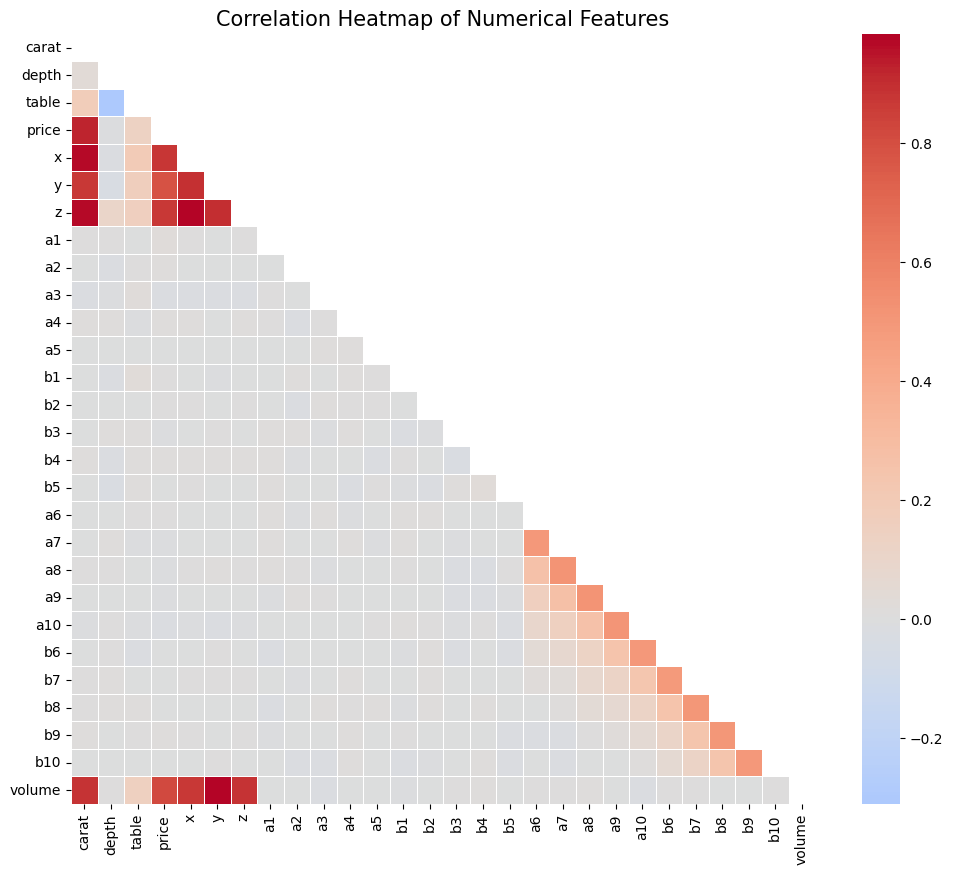

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features for the heatmap
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12, 10))
corr_matrix = X_train[numerical_cols].corr()

# Create a mask to hide the upper triangle (cleaner look)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=15)
plt.savefig('correlation_heatmap.png')
plt.show()

In [7]:
model = XGBRegressor(
    n_estimators=1000, 
    max_depth=3, 
    learning_rate=0.01, 
    subsample=0.9, 
    random_state=123
)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [8]:
# 1. Prepare data for the learning curve
# We use the evaluation set feature of XGBoost
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)

# 2. Extract results
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# 3. Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.legend()
plt.ylabel('RMSE (Error)')
plt.xlabel('Number of Estimators (Trees)')
plt.title('XGBoost Learning Curve: Training vs. Validation Error')
plt.grid(True, alpha=0.3)
plt.savefig('learning_curve.png')
plt.show()

TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(
    XGBRegressor(random_state=123), 
    param_distributions=param_grid, 
    n_iter=10, 
    cv=3, 
    scoring='r2', 
    random_state=123
)

random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Search R2: {random_search.best_score_:.4f}")

# Update your model with these best parameters
best_xgb = random_search.best_estimator_

Best Parameters: {'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01}
Best Search R2: 0.4727


In [ ]:
from sklearn.model_selection import cross_val_score
# Combine your best XGB params with a small Learning Rate decrease
model_v2 = XGBRegressor(
    n_estimators=2000, # Increased
    learning_rate=0.005, # Decreased for better precision
    max_depth=4, # Slightly deeper
    subsample=0.8,
    colsample_bytree=0.8, # Feature sampling helps generalization
    random_state=123
)

# Use 5-fold CV to check improvement
scores_v2 = cross_val_score(model_v2, X_encoded, y, cv=5, scoring='r2')
print(f"New Mean R2: {scores_v2.mean():.4f}")

New Mean R2: 0.4758


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


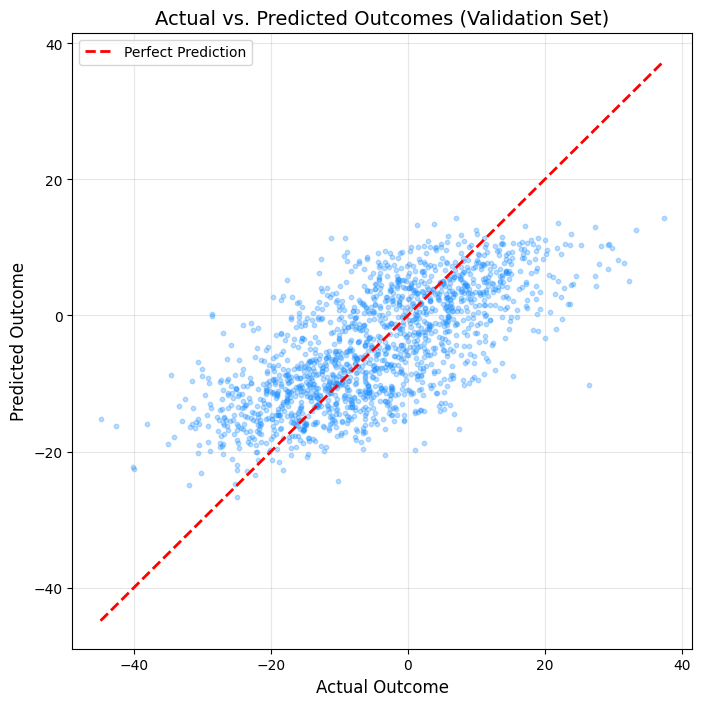

In [ ]:
from sklearn.model_selection import train_test_split

# We need a quick validation set to plot actual vs predicted
X_train_v, X_val_v, y_train_v, y_val_v = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
model.fit(X_train_v, y_train_v)
val_preds = model.predict(X_val_v)

plt.figure(figsize=(8, 8))
plt.scatter(y_val_v, val_preds, alpha=0.3, color='dodgerblue', s=10)

# Add a 45-degree line (Perfect Prediction Line)
max_val = max(y_val_v.max(), val_preds.max())
min_val = min(y_val_v.min(), val_preds.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Outcome', fontsize=12)
plt.ylabel('Predicted Outcome', fontsize=12)
plt.title('Actual vs. Predicted Outcomes (Validation Set)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('actual_vs_predicted.png')
plt.show()

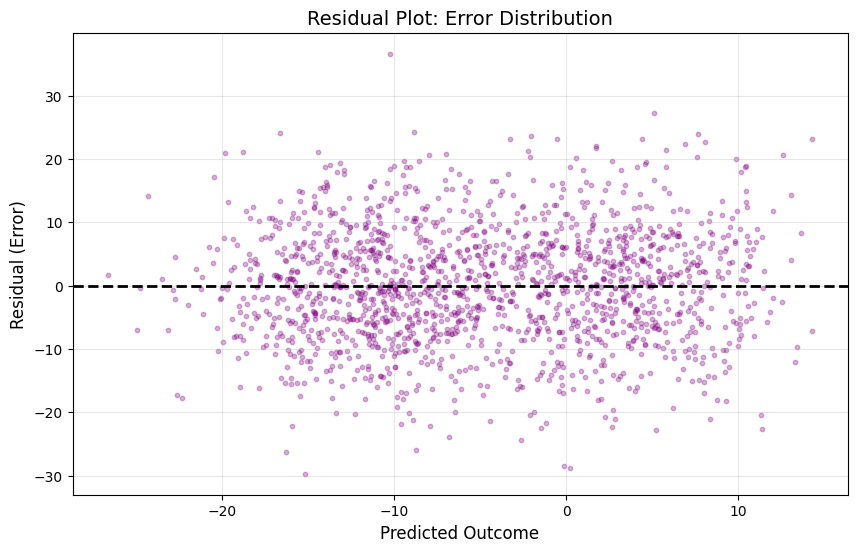

In [ ]:
residuals = y_val_v - val_preds

plt.figure(figsize=(10, 6))
plt.scatter(val_preds, residuals, alpha=0.3, color='purple', s=10)
plt.axhline(y=0, color='black', linestyle='--', lw=2)

plt.xlabel('Predicted Outcome', fontsize=12)
plt.ylabel('Residual (Error)', fontsize=12)
plt.title('Residual Plot: Error Distribution', fontsize=14)
plt.grid(alpha=0.3)
plt.savefig('residual_plot.png')
plt.show()

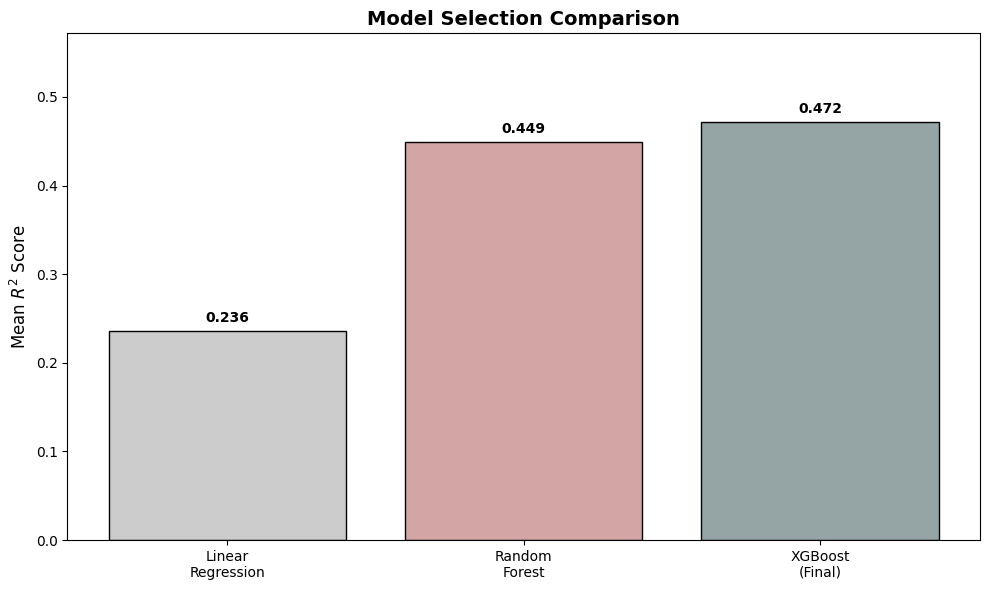

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# 1. Define the models to compare
comparison_models = {
    "Linear\nRegression": LinearRegression(),
    "Random\nForest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123),
    "XGBoost\n(Final)": XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.01, random_state=123)
}

# 2. Calculate scores
results = {}
for name, mod in comparison_models.items():
    score = cross_val_score(mod, X_train, y_train, cv=5, scoring='r2').mean()
    results[name] = score

# 3. Plotting
plt.figure(figsize=(10, 6))
colors = ['#cccccc', '#d4a5a5', '#95a5a6', '#3498db'] # XGBoost in distinct blue
plt.bar(results.keys(), results.values(), color=colors, edgecolor='black')

plt.ylabel('Mean $R^2$ Score', fontsize=12)
plt.title('Model Selection Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, max(results.values()) + 0.1)

for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison_expanded.png')
plt.show()

Calculating baseline scores...
Calculating XGBoost scores...


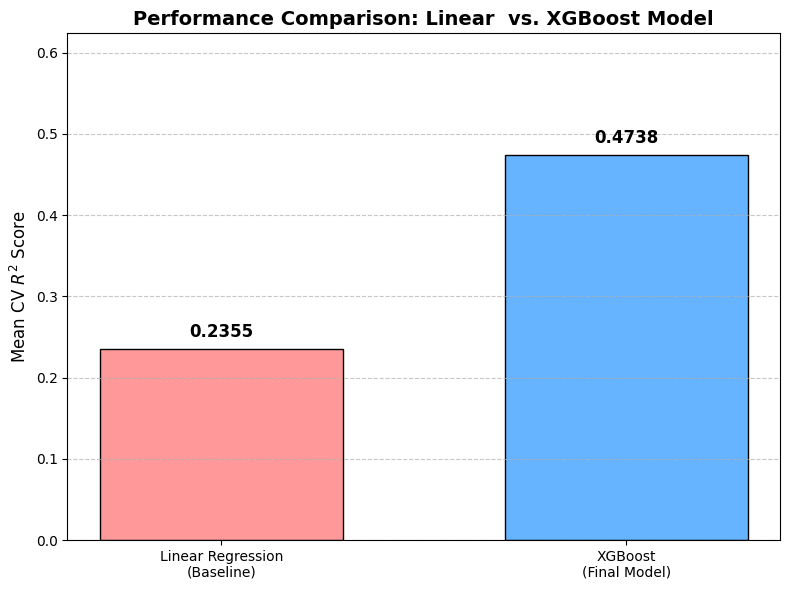

Linear Regression Mean R2: 0.2355
XGBoost Mean R2: 0.4738


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize the Baseline Linear Regression
lr_baseline = LinearRegression()

# 2. Calculate Cross-Validated R2 scores for both models
# We use 5-fold CV to get a robust 'out-of-sample' estimate
print("Calculating baseline scores...")
lr_cv_scores = cross_val_score(lr_baseline, X_train, y_train, cv=5, scoring='r2')
print("Calculating XGBoost scores...")
xgb_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Store the means
lr_mean = lr_cv_scores.mean()
xgb_mean = xgb_cv_scores.mean()

# 3. Plotting the results
model_names = ['Linear Regression\n(Baseline)', 'XGBoost\n(Final Model)']
r2_scores = [lr_mean, xgb_mean]

plt.figure(figsize=(8, 6))
colors = ['#ff9999', '#66b3ff']
bars = plt.bar(model_names, r2_scores, color=colors, edgecolor='black', width=0.6)

plt.ylabel('Mean CV $R^2$ Score', fontsize=12)
plt.title('Performance Comparison: Linear  vs. XGBoost Model', fontsize=14, fontweight='bold')
plt.ylim(0, max(r2_scores) + 0.15) # Adjust height to fit labels

# Add the specific scores on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot for your report
plt.savefig('model_comparison.png')
plt.show()

print(f"Linear Regression Mean R2: {lr_mean:.4f}")
print(f"XGBoost Mean R2: {xgb_mean:.4f}")

C:\Users\Alma\AppData\Local\Temp\ipykernel_13500\3752975587.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


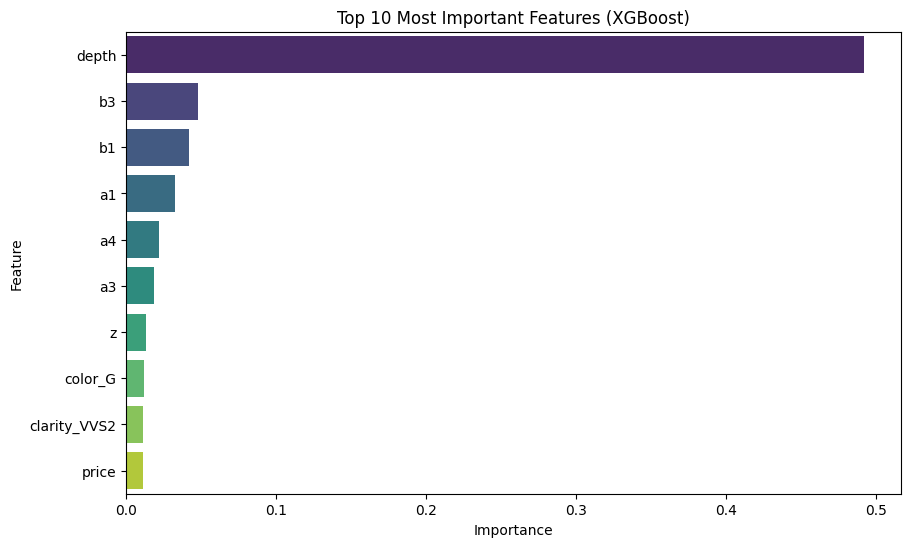

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get importance from XGBoost
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.show()

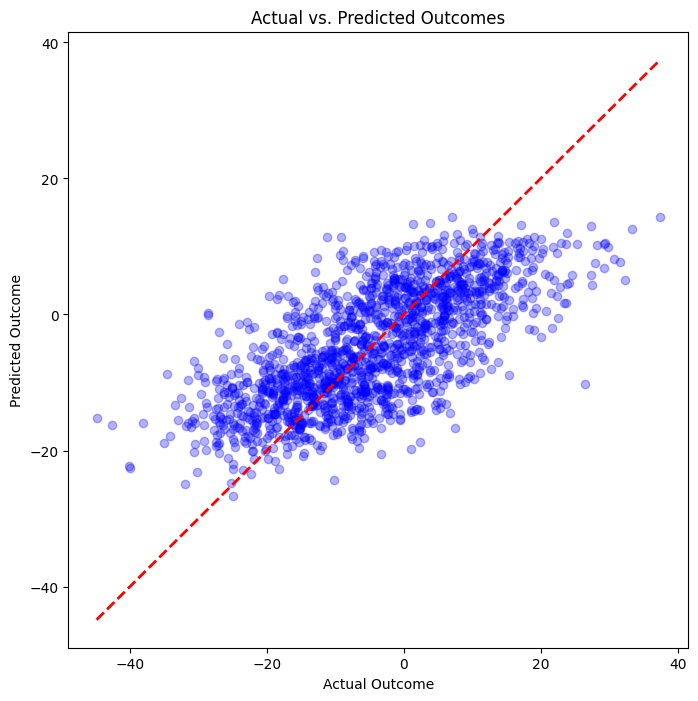

In [ ]:
# Create a quick validation split to visualize performance
X_train_viz, X_val_viz, y_train_viz, y_val_viz = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
model.fit(X_train_viz, y_train_viz)
val_preds = model.predict(X_val_viz)

plt.figure(figsize=(8, 8))
plt.scatter(y_val_viz, val_preds, alpha=0.3, color='blue')
plt.plot([y_val_viz.min(), y_val_viz.max()], [y_val_viz.min(), y_val_viz.max()], 'r--', lw=2)
plt.xlabel('Actual Outcome')
plt.ylabel('Predicted Outcome')
plt.title('Actual vs. Predicted Outcomes')
plt.show()